In [1]:
from pykrx import stock
from pandas import Series
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import time

# class 선언

- backtesting('stock_code','start_date','end_date')

In [2]:
class backtesting:
    
    def __init__(self,i,start_date,end_date):
        self.k_list = []
        self.cagr_list = []
        self.mdd_list = []
        self.cagr_bench_list = []
        self.i = i
        self.start_date = start_date
        self.end_date = end_date
        self.name = ""
    
    def test(self):
        a = stock.get_market_ohlcv_by_date(self.start_date,self.end_date, self.i)   # 개별종목
        name = stock.get_market_ticker_name(self.i) 
        self.name = name
        '''
        else:
            a = stock.get_index_ohlcv_by_date(self.start_date,self.end_date,self.i)     # 인덱스
            name = stock.get_index_ticker_name(self.i)
            self.name = name
        '''

        if a.empty:                       # 불러온 data가 없으면 넘어가기
            return


        for j in range(100,-1,-5):
            k = j/100
            df = a
            df = df[df['시가'] !=0].copy()
            df['변동폭'] = df['고가'] - df['저가']
            df['목표가'] = df['시가'] + df['변동폭'].shift(1) * k
            df['다음날시가'] = df['시가'].shift(-1)
            df = df.dropna()
            df['시그널'] = df['고가'] > df['목표가']
            df['전고점'] = 0

            start_money =10_000_000
            high = start_money
            slipage = 0.03


            for i, row in df.iterrows() :
                if df.at[i,'시그널'] == True:
                    df.at[i,'매수가능주수'] = start_money//df.at[i,'목표가']
                    df.at[i,'매도시수익금'] = (df.at[i,'다음날시가'] - df.at[i,'목표가'])*df.at[i,'매수가능주수']
                    df.at[i,'기존자산'] = start_money
                    df.at[i,'자산'] = start_money + df.at[i,'매도시수익금']
                    df.at[i,'수익률'] = 100*(df.at[i,'자산']-df.at[i,'기존자산'])/df.at[i,'기존자산']
                    start_money = df.at[i,'자산']
                    df.at[i,'전고점'] = max(high,df.at[i,'기존자산'])
                    high = df.at[i,'전고점']
                    df.at[i,'MDD'] = 100*(df.at[i,'전고점']-df.at[i,'자산'])/df.at[i,'전고점']
                else:
                    df.at[i,'자산'] = start_money
                    df.at[i,'기존자산'] = start_money
                    df.at[i,'수익률'] = 0


            MDD = df['MDD'].max()
            trade_day = int(len(df.index))
            cagr = ((df['자산'][-1]/df['자산'][0])**(252/trade_day)-1)*100
            cagr_bench = ((df['종가'][-1]/df['종가'][0])**(252/trade_day)-1)*100

            self.k_list.append(k)
            self.cagr_list.append(cagr)
            self.cagr_bench_list.append(cagr_bench)
            self.mdd_list.append(MDD)

            df_return = pd.DataFrame([self.k_list,self.cagr_list,self.mdd_list,self.cagr_bench_list])
            df_return = df_return.transpose()
            df_return.columns = ['k','cagr','mdd','cagr_bench']
        print(df_return) #(k_list,cagr_list,mdd_list,cagr_bench_list)
        
    def plot(self):
        plt.style.use('default')
        plt.rcParams['figure.figsize'] = (8,4)
        plt.rcParams['font.size'] = 10



        x = self.k_list
        y1 = self.cagr_list
        y2 = self.mdd_list
        y3 = self.cagr_bench_list


        fig, ax1 = plt.subplots()
        title = self.start_date + "~" + self.end_date
        ax1.set_title(title)
        ax1.bar(x,y1, color = 'red', label = 'cagr', alpha=0.7, width = 0.03)
        ax1.bar(x,y3, color = 'blue', label = 'cagr_bench', alpha=0.7, width = 0.01)
        #axl.xticks(len(x),x)
        ax1.set_xlabel('k')
        ax1.set_ylabel('CAGR')
        ax1.legend(loc='upper left')
        ax1.invert_xaxis()


        ax2 = ax1.twinx()
        ax2.plot(x,y2, '-s', color='green', markersize=5, linewidth=2, alpha=5, label = 'mdd')
        ax2.set_xlabel('k')
        ax2.set_ylabel('MDD')
        ax2.legend(loc='upper right')
        #ax2.invert_xaxis()

        print(self.name)
        plt.show()


    #CAGR_MDD_PLOT(name,k_list,cagr_list,cagr_bench_list,mdd_list,start_date,end_date)

# code번호 가져오는 함수 선언 

- 시가총액 기준

In [3]:
def get_stock_by_cap(num):
    df = stock.get_market_cap_by_ticker("20210326")
    big = list(df.sort_values(by='시가총액',ascending=False)[:num].index)
    return big

# 실행 해보기

## start_date, end_date, code 선언

In [4]:
start_date = "20150101"
end_date = "20210328"
code = '005930'

## class 객체 만들기

In [5]:
one = backtesting(code,start_date,end_date)

## class안에 test함수 실행

In [6]:
one.test()

       k       cagr        mdd  cagr_bench
0   1.00  14.965267  10.261639   20.177752
1   0.95  12.637994  16.015041   20.177752
2   0.90  15.574371  14.198766   20.177752
3   0.85  18.972082  13.021049   20.177752
4   0.80  20.230934  12.870455   20.177752
5   0.75  22.916522  12.752379   20.177752
6   0.70  23.453702  13.533331   20.177752
7   0.65  25.449165  14.115987   20.177752
8   0.60  26.373547  18.048673   20.177752
9   0.55  26.359078  18.557650   20.177752
10  0.50  30.608209  15.514792   20.177752
11  0.45  29.366050  16.031050   20.177752
12  0.40  33.004807  17.820681   20.177752
13  0.35  30.835358  20.114875   20.177752
14  0.30  37.740145  20.640284   20.177752
15  0.25  37.387969  21.008985   20.177752
16  0.20  35.634047  24.445737   20.177752
17  0.15  34.132599  30.610189   20.177752
18  0.10  44.623985  28.815581   20.177752
19  0.05  46.716826  33.940604   20.177752
20  0.00  64.741548  30.840035   20.177752


## class안에 plot 함수 실행  

- test 함수 실행 후에 해야한다.

삼성전자


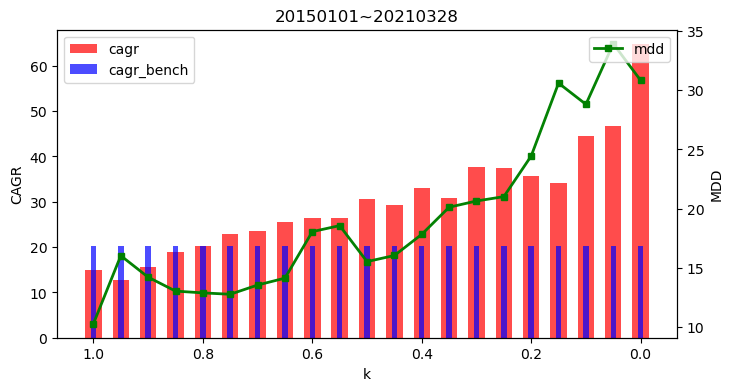

In [7]:
one.plot()

## 여러 종목 

- 시가총액 상위 10개

       k       cagr        mdd  cagr_bench
0   1.00  14.965267  10.261639   20.177752
1   0.95  12.637994  16.015041   20.177752
2   0.90  15.574371  14.198766   20.177752
3   0.85  18.972082  13.021049   20.177752
4   0.80  20.230934  12.870455   20.177752
5   0.75  22.916522  12.752379   20.177752
6   0.70  23.453702  13.533331   20.177752
7   0.65  25.449165  14.115987   20.177752
8   0.60  26.373547  18.048673   20.177752
9   0.55  26.359078  18.557650   20.177752
10  0.50  30.608209  15.514792   20.177752
11  0.45  29.366050  16.031050   20.177752
12  0.40  33.004807  17.820681   20.177752
13  0.35  30.835358  20.114875   20.177752
14  0.30  37.740145  20.640284   20.177752
15  0.25  37.387969  21.008985   20.177752
16  0.20  35.634047  24.445737   20.177752
17  0.15  34.132599  30.610189   20.177752
18  0.10  44.623985  28.815581   20.177752
19  0.05  46.716826  33.940604   20.177752
20  0.00  64.741548  30.840035   20.177752
삼성전자


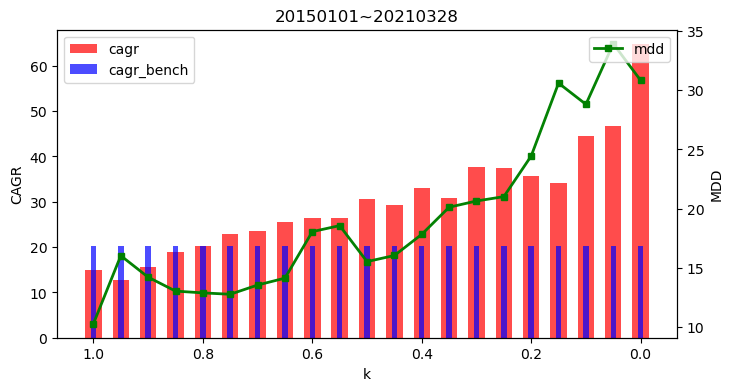

       k       cagr        mdd  cagr_bench
0   1.00  24.271182  11.254694   18.419719
1   0.95  28.107295  10.543103   18.419719
2   0.90  31.757637  10.533309   18.419719
3   0.85  31.612808   9.836459   18.419719
4   0.80  32.690284   9.253244   18.419719
5   0.75  33.071330  14.053330   18.419719
6   0.70  35.267144  13.772812   18.419719
7   0.65  39.917533  13.224383   18.419719
8   0.60  44.972910  15.363771   18.419719
9   0.55  42.434384  19.630532   18.419719
10  0.50  53.355112  16.730833   18.419719
11  0.45  45.408072  24.748210   18.419719
12  0.40  44.297685  27.651252   18.419719
13  0.35  45.592573  25.980942   18.419719
14  0.30  43.118142  23.111128   18.419719
15  0.25  43.617616  35.380012   18.419719
16  0.20  40.656395  41.082554   18.419719
17  0.15  48.061165  42.714629   18.419719
18  0.10  48.350233  38.117136   18.419719
19  0.05  47.548636  42.062296   18.419719
20  0.00  67.395730  38.332082   18.419719
SK하이닉스


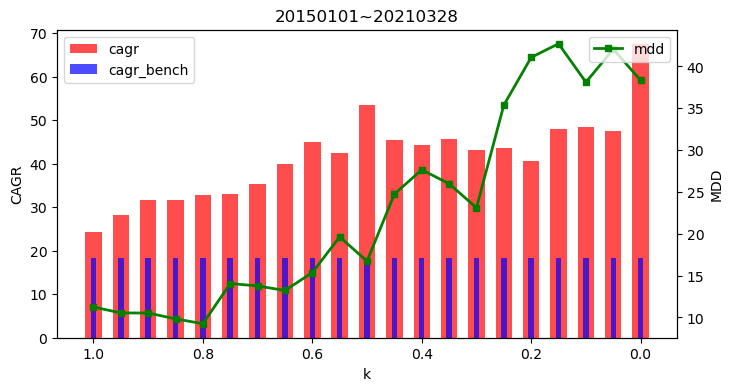

       k       cagr        mdd  cagr_bench
0   1.00  14.898044   8.726600   16.577549
1   0.95  15.511244  10.476085   16.577549
2   0.90  19.048352   8.544430   16.577549
3   0.85  19.768683   9.854570   16.577549
4   0.80  20.900829  10.504405   16.577549
5   0.75  23.272902   9.822340   16.577549
6   0.70  22.608425  13.358485   16.577549
7   0.65  23.191505  14.725288   16.577549
8   0.60  27.365003  14.066470   16.577549
9   0.55  23.701720  19.344709   16.577549
10  0.50  26.582711  24.973030   16.577549
11  0.45  21.035570  33.012124   16.577549
12  0.40  19.151512  35.263700   16.577549
13  0.35  15.939484  38.432591   16.577549
14  0.30  20.079334  34.224382   16.577549
15  0.25  26.238709  26.547143   16.577549
16  0.20  25.464682  33.140639   16.577549
17  0.15  25.881424  30.581521   16.577549
18  0.10  44.873095  30.637440   16.577549
19  0.05  48.830718  29.282265   16.577549
20  0.00  83.842437  21.001742   16.577549
NAVER


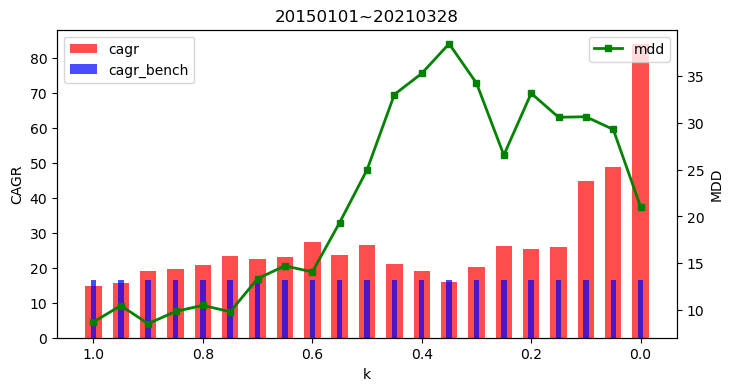

       k       cagr        mdd  cagr_bench
0   1.00  18.839566  11.032533   23.709332
1   0.95  17.121871  11.011183   23.709332
2   0.90  18.768285  10.347669   23.709332
3   0.85  18.932237  15.167395   23.709332
4   0.80  19.577320  13.979894   23.709332
5   0.75  21.244483  13.883545   23.709332
6   0.70  21.756826  13.460538   23.709332
7   0.65  23.829634  12.140778   23.709332
8   0.60  25.353049  13.210133   23.709332
9   0.55  23.689273  23.194395   23.709332
10  0.50  29.238259  22.082456   23.709332
11  0.45  26.278910  25.310884   23.709332
12  0.40  26.779541  27.693508   23.709332
13  0.35  22.340332  35.238664   23.709332
14  0.30  25.387557  35.760685   23.709332
15  0.25  35.391641  23.759916   23.709332
16  0.20  32.696504  24.960695   23.709332
17  0.15  36.261827  32.414553   23.709332
18  0.10  44.973727  28.008441   23.709332
19  0.05  48.608444  35.106690   23.709332
20  0.00  71.913953  31.848394   23.709332
삼성전자우


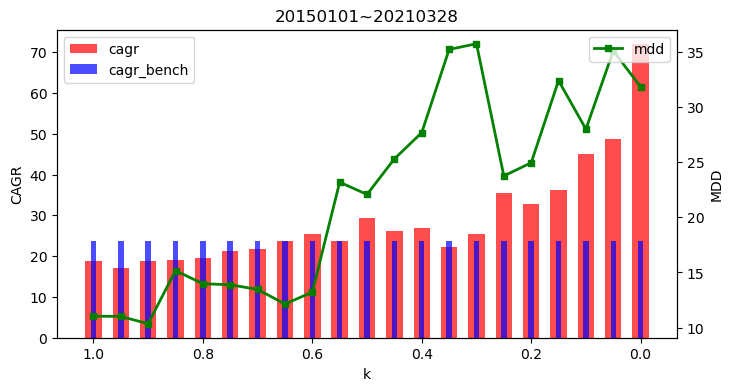

       k       cagr        mdd  cagr_bench
0   1.00  30.968207   6.410391   28.185237
1   0.95  32.625999   8.142913   28.185237
2   0.90  34.055192   8.812850   28.185237
3   0.85  37.855341   8.361111   28.185237
4   0.80  38.922965  13.147933   28.185237
5   0.75  41.804791  12.768111   28.185237
6   0.70  39.426351  11.881864   28.185237
7   0.65  37.969411  14.028117   28.185237
8   0.60  39.397702  15.065419   28.185237
9   0.55  39.767971  12.998088   28.185237
10  0.50  45.616676  19.242024   28.185237
11  0.45  39.626249  19.707888   28.185237
12  0.40  47.028590  20.564857   28.185237
13  0.35  35.975387  26.543511   28.185237
14  0.30  45.124532  26.762109   28.185237
15  0.25  38.966769  32.760213   28.185237
16  0.20  42.368555  33.963687   28.185237
17  0.15  40.008599  41.996608   28.185237
18  0.10  49.594502  39.071910   28.185237
19  0.05  46.248374  35.450828   28.185237
20  0.00  76.711072  41.457303   28.185237
LG화학


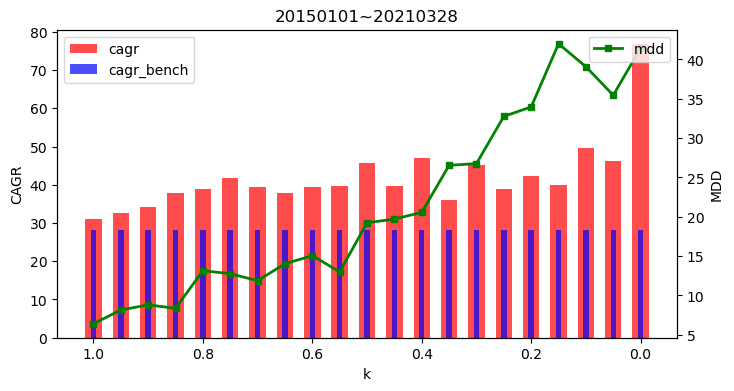

       k       cagr        mdd  cagr_bench
0   1.00  49.958971  18.113546   42.862516
1   0.95  49.700541  16.478627   42.862516
2   0.90  53.258509  15.273062   42.862516
3   0.85  52.846056  13.337690   42.862516
4   0.80  60.439050  10.653993   42.862516
5   0.75  66.134704  11.860223   42.862516
6   0.70  59.321069  11.410816   42.862516
7   0.65  57.986552  10.671148   42.862516
8   0.60  64.580983  15.474834   42.862516
9   0.55  69.878587  16.700400   42.862516
10  0.50  79.367337  17.378466   42.862516
11  0.45  72.724161  25.562588   42.862516
12  0.40  70.624745  32.312430   42.862516
13  0.35  72.978455  30.839746   42.862516
14  0.30  78.217235  37.922351   42.862516
15  0.25  89.685781  35.733679   42.862516
16  0.20  87.430379  38.138565   42.862516
17  0.15  58.774401  42.557312   42.862516
18  0.10  73.450239  40.813042   42.862516
19  0.05  76.029917  39.183908   42.862516
20  0.00  96.602145  45.598426   42.862516
삼성바이오로직스


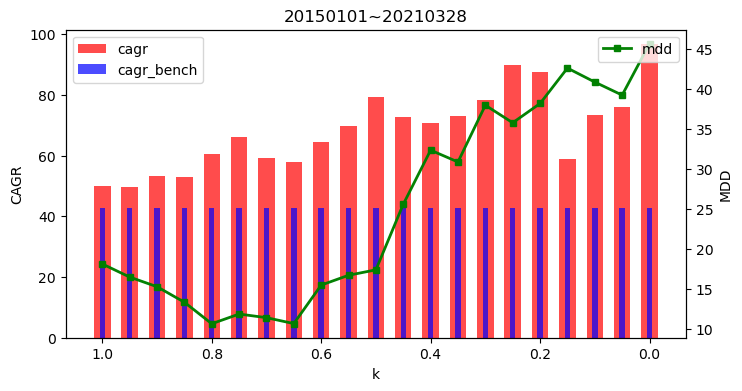

       k       cagr        mdd  cagr_bench
0   1.00  17.295593  10.650868    4.384499
1   0.95   9.254413  26.657880    4.384499
2   0.90  14.776820  14.099620    4.384499
3   0.85  16.902287  13.871104    4.384499
4   0.80  19.890358  12.234005    4.384499
5   0.75  19.618270  20.235600    4.384499
6   0.70  15.892882  33.751897    4.384499
7   0.65  12.437027  45.680207    4.384499
8   0.60  19.265333  36.473457    4.384499
9   0.55  12.565015  50.983401    4.384499
10  0.50  26.113785  32.546148    4.384499
11  0.45  20.485059  48.548237    4.384499
12  0.40  22.093211  44.796054    4.384499
13  0.35  20.661457  53.534933    4.384499
14  0.30  14.457149  55.676485    4.384499
15  0.25  20.529640  37.763813    4.384499
16  0.20   9.893320  51.845154    4.384499
17  0.15  -4.370730  78.322556    4.384499
18  0.10  -7.816144  82.452369    4.384499
19  0.05   8.429911  54.800795    4.384499
20  0.00  45.344699  46.731433    4.384499
현대차


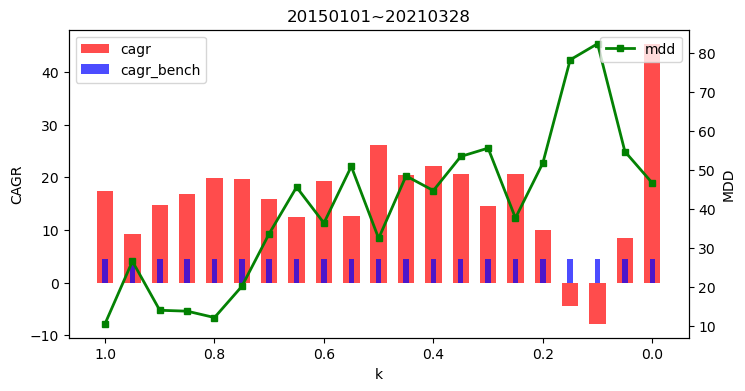

       k        cagr        mdd  cagr_bench
0   1.00   34.013376  11.936182   32.502558
1   0.95   28.392237  13.467084   32.502558
2   0.90   35.730191  12.123421   32.502558
3   0.85   41.256117  14.101344   32.502558
4   0.80   44.732942  14.188274   32.502558
5   0.75   48.915462  16.822066   32.502558
6   0.70   48.308729  16.214149   32.502558
7   0.65   53.384787  18.376149   32.502558
8   0.60   58.236836  19.062877   32.502558
9   0.55   57.037706  19.140155   32.502558
10  0.50   72.519797  19.540926   32.502558
11  0.45   65.884539  21.471679   32.502558
12  0.40   74.203227  20.409074   32.502558
13  0.35   76.103656  20.826697   32.502558
14  0.30   79.206999  26.135701   32.502558
15  0.25   91.762833  23.530374   32.502558
16  0.20   99.325641  31.326103   32.502558
17  0.15   81.577194  44.603117   32.502558
18  0.10   90.944766  42.908624   32.502558
19  0.05   85.982944  39.401148   32.502558
20  0.00  135.875194  42.467378   32.502558
삼성SDI


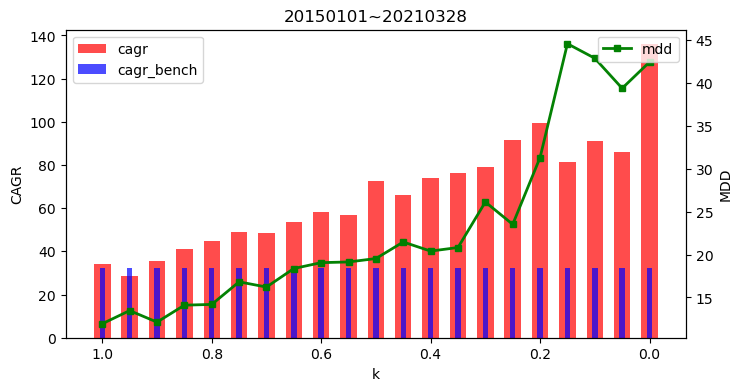

       k       cagr        mdd  cagr_bench
0   1.00  39.280752   5.668791   22.071568
1   0.95  36.335860   8.136000   22.071568
2   0.90  35.433517  10.186334   22.071568
3   0.85  35.670630  10.514968   22.071568
4   0.80  36.966999  12.399000   22.071568
5   0.75  37.205667  13.917079   22.071568
6   0.70  35.071479  15.055412   22.071568
7   0.65  30.486500  18.903344   22.071568
8   0.60  35.119684  15.506372   22.071568
9   0.55  34.803881  16.636340   22.071568
10  0.50  44.194670  17.214238   22.071568
11  0.45  37.714656  27.278300   22.071568
12  0.40  39.086848  26.959066   22.071568
13  0.35  29.795559  33.963381   22.071568
14  0.30  36.280779  29.806872   22.071568
15  0.25  42.704143  27.444302   22.071568
16  0.20  41.590878  31.692262   22.071568
17  0.15  30.578435  42.323393   22.071568
18  0.10  30.527044  43.623245   22.071568
19  0.05  35.263472  49.350630   22.071568
20  0.00  67.707639  35.765188   22.071568
카카오


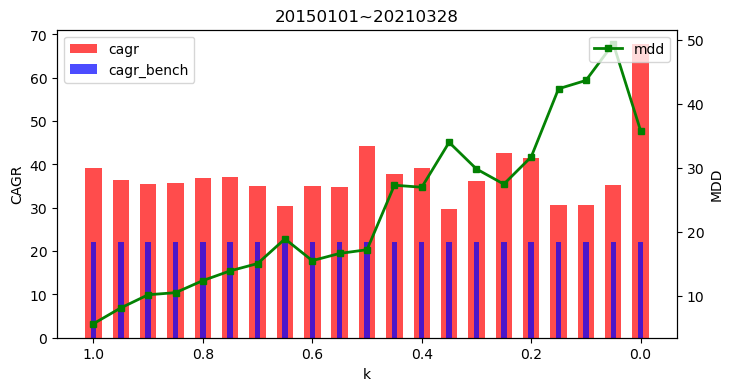

       k        cagr        mdd  cagr_bench
0   1.00   58.439279  10.968947   42.801865
1   0.95   62.087416  10.281902   42.801865
2   0.90   64.699108  11.033418   42.801865
3   0.85   66.229870  17.737230   42.801865
4   0.80   74.833401  17.113697   42.801865
5   0.75   80.677808  20.344060   42.801865
6   0.70   81.574455  20.396035   42.801865
7   0.65   91.672017  19.210253   42.801865
8   0.60   93.161655  17.744606   42.801865
9   0.55   93.492455  17.264578   42.801865
10  0.50   94.628973  22.714800   42.801865
11  0.45  101.463453  21.597514   42.801865
12  0.40   93.825866  25.547554   42.801865
13  0.35   81.430931  25.040968   42.801865
14  0.30   75.798495  36.701471   42.801865
15  0.25   71.106859  36.425617   42.801865
16  0.20   78.432775  33.864398   42.801865
17  0.15   77.272425  36.517861   42.801865
18  0.10   57.138905  58.183564   42.801865
19  0.05   67.615794  65.264728   42.801865
20  0.00   84.885374  47.519521   42.801865
셀트리온


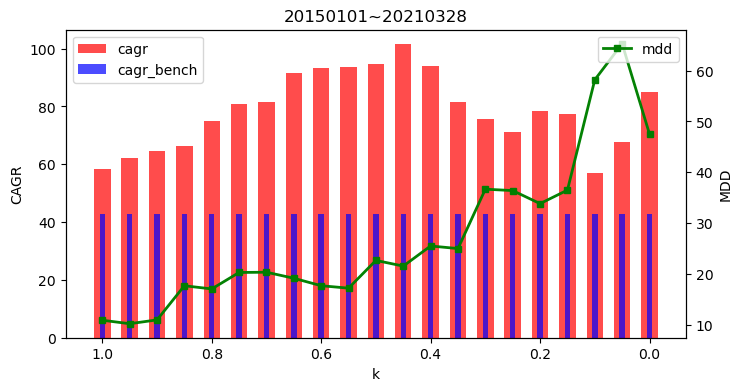

In [8]:
code_list = get_stock_by_cap(10)
start_date = "20150101"
end_date = "20210328"
for i in code_list:
    a = backtesting(i,start_date,end_date)
    a.test()
    a.plot()